In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import random as rand
import sys
from scipy.stats import norm
import math

# Stocks and Hedges

In [292]:
class stock:
    def __init__(self, dt, T, Scur, mu, sigma, strike_price):
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.N = math.ceil(T/dt)
        self.T = self.N*dt
        self.N += 1
        self.Scur = Scur
        self.Tcur = 0.0
        self.K = strike_price
        
        #tests:
#         self.counter = 0
#         self.stock_list = [self.Scur,48.12,47.37,50.25,51.75,53.12,53.00,51.87,51.38,53.00,49.88,48.50,49.88,50.37,52.13,51.88,52.87,54.87,54.62,55.87,57.25]
#         self.stock_list = [self.Scur,48.12,47.37,50.25,51.75,53.12,53.00,51.87,51.38,53.00,49.88,48.50,49.88,50.37,52.13,51.88,52.87,54.87,54.62,55.87,52]
        
    def update_mu(self,new_mu):
        self.mu = new_mu
    def update_sigma(self,new_sigma):
        self.sigma = new_sigma
        
    def sample(self): #probably not needed
        eps = rand.normal(0,1)
        return Scur*(1 + self.mu*Tcur + self.sigma*eps*np.sqrt(dt))
    def step(self):
        eps = rand.normal(0,1)
        self.Tcur += dt
        self.Scur = self.Scur*(1 + self.mu*self.Tcur + self.sigma*eps*np.sqrt(dt))
#         self.counter+=1
#         if self.counter < self.N:
#             self.Scur = self.stock_list[self.counter]
# #             print(self.counter,self.Scur)
        return self.Scur    
        

In [288]:
class delta_hedge_process:
    def long_call_hedge(self,stock):
        S = stock.Scur
        K = stock.K
        tau = stock.T - stock.Tcur
        sigma = stock.sigma
        r = self.risk_free
        d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
        return norm.cdf(d_plus)
    def NEW_LCH(self,stock):
        S = stock.Scur
        K = stock.K
        tau = stock.T - stock.Tcur
        sigma = stock.sigma
        r = self.risk_free
        d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
        d_minus = d_plus - sigma*np.sqrt(tau)
        C = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
        return C/S
        
    def __init__(self, hedge_types, rfRate, stock_args, contracts=1):
    # all functions above should have a place in this dictionary
        self.hedge_dict = {"long call":self.long_call_hedge,"new long call":self.NEW_LCH}
        
    # All time should be given in units of years
        self.risk_free = rfRate
        self.r_eff = rfRate*dt
        self.stock = stock(*stock_args)
        self.num_of_contracts = contracts 
        
        self.hedge_types = hedge_types
        self.hedges_to_do = [self.hedge_dict[hedge] for hedge in hedge_types]
        self.FINAL_PRICE = [0 for i in range(len(hedge_types))]
        
    def process_to_maturity(self):
        num_of_hedge_types = len(self.hedges_to_do)
        S_of_t = []
        cost_of_t = [[] for i in range(num_of_hedge_types)]
        cumul_cost_of_t = [[] for i in range(num_of_hedge_types)]
        loan_of_t = [[] for i in range(num_of_hedge_types)]
        interest_of_t = [[] for i in range(num_of_hedge_types)]
        shares_of_t = [[] for i in range(num_of_hedge_types)]
        cumul_shares_of_t = [[] for i in range(num_of_hedge_types)]
        
        shares = [0 for i in range(num_of_hedge_types)]
        cumul_shares = [0 for i in range(num_of_hedge_types)]
        interest = [0 for i in range(num_of_hedge_types)]
        cost = [0 for i in range(num_of_hedge_types)]
        cumul_cost = [0 for i in range(num_of_hedge_types)]
        
        for i in range(self.stock.N):
            S = self.stock.Scur
            S_of_t.append(S)
            for j in range(num_of_hedge_types):
                delta = self.hedges_to_do[j](self.stock)
                shares[j] = delta - cumul_shares[j]
                cumul_shares[j] += shares[j]
                cost[j] = shares[j]*S
                cumul_cost[j] += cost[j] + interest[j]
                
                if cumul_cost[j]>0.0:
                    interest[j] = cumul_cost[j]*self.r_eff
                    
                shares_of_t[j].append(shares[j])
                cumul_shares_of_t[j].append(cumul_shares[j])
                cost_of_t[j].append(cost[j])
                cumul_cost_of_t[j].append(cumul_cost[j])
                interest_of_t[j].append(interest[j])
                
            self.stock.step()
            
        for j in range(num_of_hedge_types):
#             final_sell = -S_of_t[-1]*cumul_shares_of_t[j][-1]
#             cost_of_t[j].append(final_sell)
#             cumul_cost_of_t[j].append(cumul_cost_of_t[j][-1]+final_sell)
            
            if cumul_shares_of_t[j][-1]==1:
                self.FINAL_PRICE[j] = cumul_cost_of_t[j][-1] - self.stock.K
            else:
                self.FINAL_PRICE[j] = cumul_cost_of_t[j][-1]
            
        return S_of_t, cost_of_t, cumul_cost_of_t, shares_of_t, cumul_shares_of_t, interest_of_t

# Running:

In [295]:
Scur = 49
strike_price = 50
rfRate = 0.05
sigma = 0.05
T = 20./52.
dt = 1./52.
mu = 0.
stock_args = (dt, T, Scur, mu, sigma, strike_price)

hedge_types = ["long call","new long call"]
my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

In [296]:
S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()

In [297]:
S

[49,
 49.19947534022709,
 49.10847809980079,
 49.68606984885561,
 49.72373094415995,
 48.938507842383444,
 49.377060276791696,
 49.35647977521518,
 49.99426102089319,
 50.12916365848353,
 49.46235614348752,
 49.15932393401958,
 48.66838043993855,
 49.11778148149688,
 48.52808221059953,
 49.112354332535894,
 49.3953578907325,
 48.944422922457306,
 48.475922569531285,
 47.991990962083,
 47.842228199246755]

In [286]:
my_delta_hedge.FINAL_PRICE

[47.226665365932575, 997.9513139412836]

# Comparing Hedging Methods Statistically

## small variance

In [306]:
S = 50
K = 50
tau = 20./52.
sigma = 0.05
r = 0.05
d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
d_minus = d_plus - sigma*np.sqrt(tau)
BS_price = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
print("Black-Scholes Price: ", BS_price)

Black-Scholes Price:  1.202956651115926


In [308]:
traditional_cost = []
my_cost = []
for i in range(10000):
    Scur = 50
    strike_price = 50
    rfRate = 0.05
    sigma = 0.05
    T = 20./52.
    dt = 1./52.
    mu = 0.
    stock_args = (dt, T, Scur, mu, sigma, strike_price)

    hedge_types = ["long call","new long call"]
    my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

    S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()
    final_prices = my_delta_hedge.FINAL_PRICE
    traditional_cost.append(final_prices[0])
    my_cost.append(final_prices[1])
    
traditional_cost = np.array(traditional_cost)
my_cost = np.array(my_cost)

In [309]:
print("Avereage traditional: ",np.mean(traditional_cost),", Average of mine: ", np.mean(my_cost))
print("Variance traditional: ",np.var(traditional_cost),", Variance of mine: ", np.var(my_cost))

Avereage traditional:  1.2314010132519804 , Average of mine:  0.6489125718250265
Variance traditional:  0.013197228023740053 , Variance of mine:  0.8253706857363994


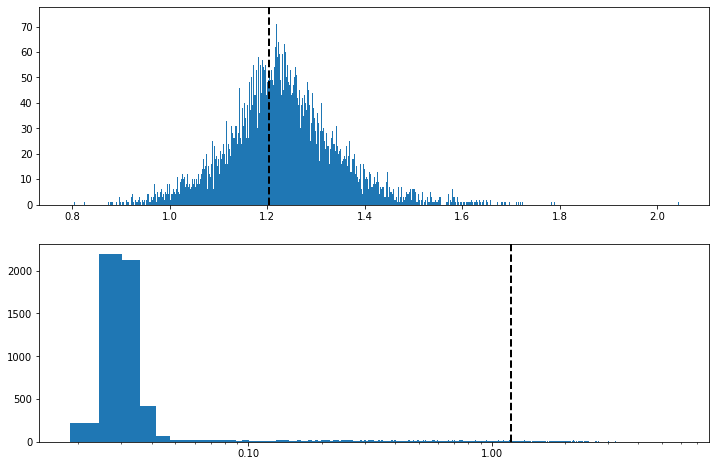

In [310]:
from matplotlib.ticker import ScalarFormatter
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
bins = 1000


ax1.hist(traditional_cost, bins=bins)
ax1.axvline(BS_price,color='k',linestyle="--",linewidth=2)
ax2.hist(my_cost, bins=bins)
ax2.set_xscale("log")
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.axvline(BS_price,color='k',linestyle="--",linewidth=2)
# ax2.xaxis.set_ticks([0.0,0.05,0.1,0.5,1.0,2,5,10])
# ax2.set_xticks([0.0,0.05,0.1,0.5,1.0,2.0]) 
# ax2.set_xticklabels([0.0,0.05,0.1,0.5,1.0,2.0], fontsize=12)


## large variance

In [79]:
S = 50
K = 50
tau = 20./52.
sigma = 0.65
r = 0.05
d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
d_minus = d_plus - sigma*np.sqrt(tau)
BS_price = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
print("Black-Scholes Price: ", BS_price)

Black-Scholes Price:  8.395816815604057


In [72]:
traditional_cost = []
my_cost = []
for i in range(10000):
    Scur = 50
    strike_price = 50
    rfRate = 0.05
    sigma = 0.65
    T = 20./52.
    dt = 1./52.
    mu = 0.
    stock_args = (dt, T, Scur, mu, sigma, strike_price)

    hedge_types = ["long call","new long call"]
    my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

    S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()
    final_prices = my_delta_hedge.FINAL_PRICE
    traditional_cost.append(final_prices[0])
    my_cost.append(final_prices[1])
    
traditional_cost = np.array(traditional_cost)
my_cost = np.array(my_cost)

print("Avereage traditional: ",np.mean(traditional_cost),", Average of mine: ", np.mean(my_cost))
print("Variance traditional: ",np.var(traditional_cost),", Variance of mine: ", np.var(my_cost))

Avereage traditional:  8.541381100213648 , Average of mine:  8.090646079949009
Variance traditional:  2.350069207835862 , Variance of mine:  102.73495998063902


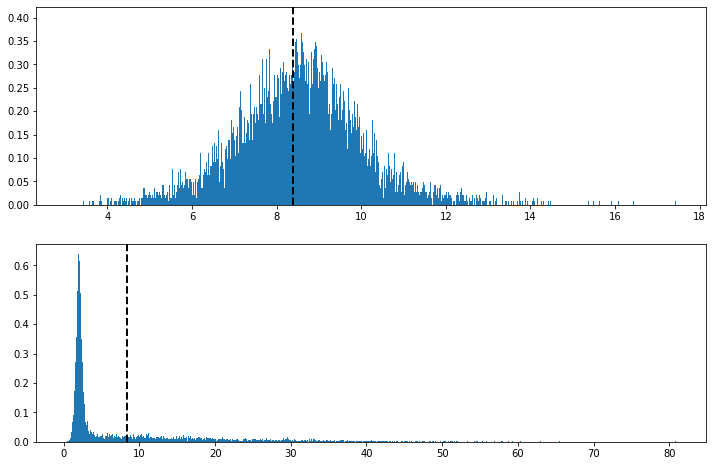

In [85]:
from matplotlib.ticker import ScalarFormatter
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
bins = 1000


ax1.hist(traditional_cost, bins=bins,density=True,stacked=True)
ax1.axvline(BS_price,color='k',linestyle="--",linewidth=2)
ax2.hist(my_cost, bins=bins,density=True,stacked=True)
ax2.axvline(BS_price,color='k',linestyle="--",linewidth=2)
# ax2.set_xscale("log")
# ax2.xaxis.set_major_formatter(ScalarFormatter())
# ax2.xaxis.set_ticks([0.0,0.05,0.1,0.5,1.0,2,5,10])
# ax2.set_xticks([0.0,0.05,0.1,0.5,1.0,2.0]) 
# ax2.set_xticklabels([0.0,0.05,0.1,0.5,1.0,2.0], fontsize=12)


## small variance, lower start price

In [94]:
S = 49
K = 50
tau = 20./52.
sigma = 0.05
r = 0.05
d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
d_minus = d_plus - sigma*np.sqrt(tau)
BS_price = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
print("Black-Scholes Price: ", BS_price)

Black-Scholes Price:  0.5829072848018519


In [95]:
traditional_cost = []
my_cost = []
for i in range(10000):
    Scur = 49
    strike_price = 50
    rfRate = 0.05
    sigma = 0.05
    T = 20./52.
    dt = 1./52.
    mu = 0.
    stock_args = (dt, T, Scur, mu, sigma, strike_price)

    hedge_types = ["long call","new long call"]
    my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

    S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()
    final_prices = my_delta_hedge.FINAL_PRICE
    traditional_cost.append(final_prices[0])
    my_cost.append(final_prices[1])
    
traditional_cost = np.array(traditional_cost)
my_cost = np.array(my_cost)

print("Avereage traditional: ",np.mean(traditional_cost),", Average of mine: ", np.mean(my_cost))
print("Variance traditional: ",np.var(traditional_cost),", Variance of mine: ", np.var(my_cost))

Avereage traditional:  0.6000564891039449 , Average of mine:  0.25430108752912584
Variance traditional:  0.012306137014250908 , Variance of mine:  0.3239393439931818


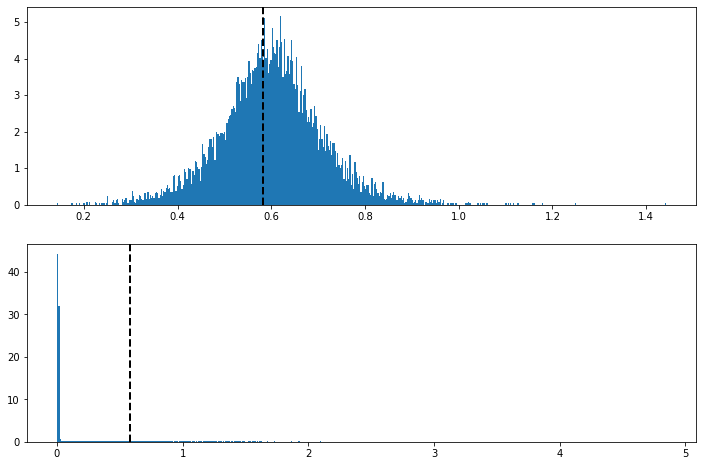

In [97]:
from matplotlib.ticker import ScalarFormatter
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
bins = 500


ax1.hist(traditional_cost, bins=bins,density=True,stacked=True)
ax1.axvline(BS_price,color='k',linestyle="--",linewidth=2)
ax2.hist(my_cost, bins=bins,density=True,stacked=True)
ax2.axvline(BS_price,color='k',linestyle="--",linewidth=2)
# ax2.set_xscale("log")
# ax2.xaxis.set_major_formatter(ScalarFormatter())
# ax2.xaxis.set_ticks([0.0,0.05,0.1,0.5,1.0,2,5,10])
# ax2.set_xticks([0.0,0.05,0.1,0.5,1.0,2.0]) 
# ax2.set_xticklabels([0.0,0.05,0.1,0.5,1.0,2.0], fontsize=12)


## small variance, higher start price

In [101]:
S = 51
K = 50
tau = 20./52.
sigma = 0.05
r = 0.05
d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
d_minus = d_plus - sigma*np.sqrt(tau)
BS_price = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
print("Black-Scholes Price: ", BS_price)

Black-Scholes Price:  2.029370376192851


In [102]:
traditional_cost = []
my_cost = []
for i in range(10000):
    Scur = 51
    strike_price = 50
    rfRate = 0.05
    sigma = 0.05
    T = 20./52.
    dt = 1./52.
    mu = 0.
    stock_args = (dt, T, Scur, mu, sigma, strike_price)

    hedge_types = ["long call","new long call"]
    my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

    S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()
    final_prices = my_delta_hedge.FINAL_PRICE
    traditional_cost.append(final_prices[0])
    my_cost.append(final_prices[1])
    
traditional_cost = np.array(traditional_cost)
my_cost = np.array(my_cost)

print("Avereage traditional: ",np.mean(traditional_cost),", Average of mine: ", np.mean(my_cost))
print("Variance traditional: ",np.var(traditional_cost),", Variance of mine: ", np.var(my_cost))

Avereage traditional:  2.073633485061812 , Average of mine:  1.2828799477120165
Variance traditional:  0.00881220458009205 , Variance of mine:  1.4361838231274842


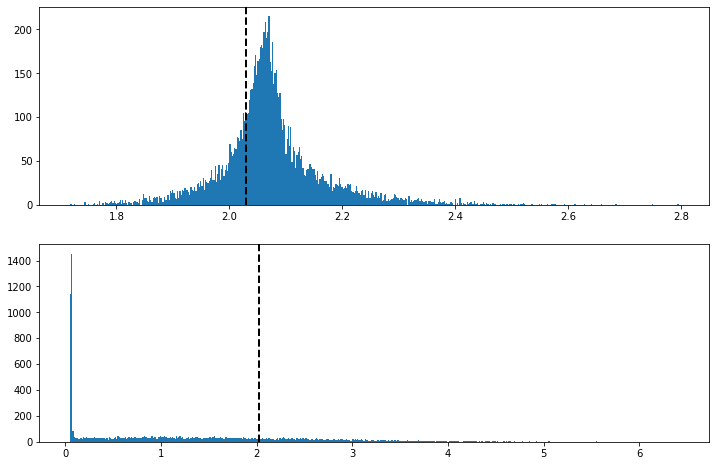

In [106]:
from matplotlib.ticker import ScalarFormatter
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
bins = 500


ax1.hist(traditional_cost, bins=bins)
ax1.axvline(BS_price,color='k',linestyle="--",linewidth=2)
ax2.hist(my_cost, bins=bins)
ax2.axvline(BS_price,color='k',linestyle="--",linewidth=2)
# ax2.set_xscale("log")
# ax2.xaxis.set_major_formatter(ScalarFormatter())
# ax2.xaxis.set_ticks([0.0,0.05,0.1,0.5,1.0,2,5,10])
# ax2.set_xticks([0.0,0.05,0.1,0.5,1.0,2.0]) 
# ax2.set_xticklabels([0.0,0.05,0.1,0.5,1.0,2.0], fontsize=12)


## high variance, lower start price

In [109]:
S = 49
K = 50
tau = 20./52.
sigma = 0.65
r = 0.05
d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
d_minus = d_plus - sigma*np.sqrt(tau)
BS_price = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
print("Black-Scholes Price: ", BS_price)

Black-Scholes Price:  7.807092508425786


In [110]:
traditional_cost = []
my_cost = []
for i in range(10000):
    Scur = 49
    strike_price = 50
    rfRate = 0.05
    sigma = 0.65
    T = 20./52.
    dt = 1./52.
    mu = 0.
    stock_args = (dt, T, Scur, mu, sigma, strike_price)

    hedge_types = ["long call","new long call"]
    my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

    S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()
    final_prices = my_delta_hedge.FINAL_PRICE
    traditional_cost.append(final_prices[0])
    my_cost.append(final_prices[1])
    
traditional_cost = np.array(traditional_cost)
my_cost = np.array(my_cost)

print("Avereage traditional: ",np.mean(traditional_cost),", Average of mine: ", np.mean(my_cost))
print("Variance traditional: ",np.var(traditional_cost),", Variance of mine: ", np.var(my_cost))

Avereage traditional:  7.999484231395003 , Average of mine:  7.564601904863796
Variance traditional:  2.32015654502022 , Variance of mine:  100.46276491886697


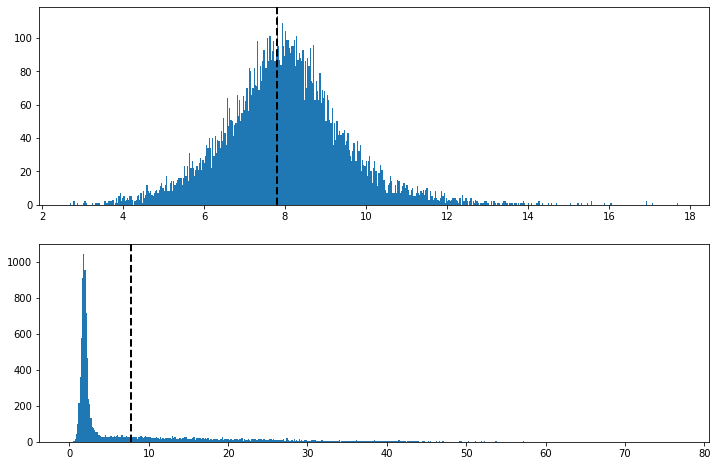

In [111]:
from matplotlib.ticker import ScalarFormatter
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
bins = 500


ax1.hist(traditional_cost, bins=bins)
ax1.axvline(BS_price,color='k',linestyle="--",linewidth=2)
ax2.hist(my_cost, bins=bins)
ax2.axvline(BS_price,color='k',linestyle="--",linewidth=2)
# ax2.set_xscale("log")
# ax2.xaxis.set_major_formatter(ScalarFormatter())
# ax2.xaxis.set_ticks([0.0,0.05,0.1,0.5,1.0,2,5,10])
# ax2.set_xticks([0.0,0.05,0.1,0.5,1.0,2.0]) 
# ax2.set_xticklabels([0.0,0.05,0.1,0.5,1.0,2.0], fontsize=12)


## high variance, higher start price

In [113]:
S = 51
K = 50
tau = 20./52.
sigma = 0.65
r = 0.05
d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
d_minus = d_plus - sigma*np.sqrt(tau)
BS_price = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
print("Black-Scholes Price: ", BS_price)

Black-Scholes Price:  9.00372754061058


In [114]:
traditional_cost = []
my_cost = []
for i in range(10000):
    Scur = 
    strike_price = 50
    rfRate = 0.05
    sigma = 0.65
    T = 20./52.
    dt = 1./52.
    mu = 0.
    stock_args = (dt, T, Scur, mu, sigma, strike_price)

    hedge_types = ["long call","new long call"]
    my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

    S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()
    final_prices = my_delta_hedge.FINAL_PRICE
    traditional_cost.append(final_prices[0])
    my_cost.append(final_prices[1])
    
traditional_cost = np.array(traditional_cost)
my_cost = np.array(my_cost)

print("Avereage traditional: ",np.mean(traditional_cost),", Average of mine: ", np.mean(my_cost))
print("Variance traditional: ",np.var(traditional_cost),", Variance of mine: ", np.var(my_cost))

Avereage traditional:  9.192327336228974 , Average of mine:  8.78914149503615
Variance traditional:  2.4333769822565254 , Variance of mine:  111.2091977012192


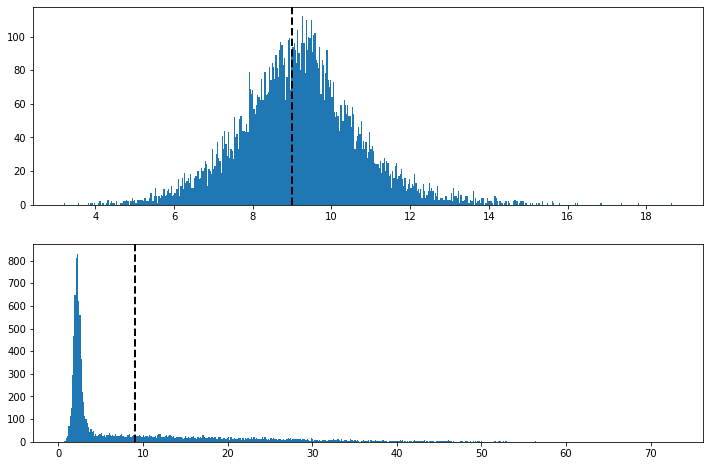

In [115]:
from matplotlib.ticker import ScalarFormatter
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
bins = 500


ax1.hist(traditional_cost, bins=bins)
ax1.axvline(BS_price,color='k',linestyle="--",linewidth=2)
ax2.hist(my_cost, bins=bins)
ax2.axvline(BS_price,color='k',linestyle="--",linewidth=2)
# ax2.set_xscale("log")
# ax2.xaxis.set_major_formatter(ScalarFormatter())
# ax2.xaxis.set_ticks([0.0,0.05,0.1,0.5,1.0,2,5,10])
# ax2.set_xticks([0.0,0.05,0.1,0.5,1.0,2.0]) 
# ax2.set_xticklabels([0.0,0.05,0.1,0.5,1.0,2.0], fontsize=12)


In [116]:
counts1, bins1 = np.histogram(traditional_cost, bins)
counts2, bins2 = np.histogram(my_cost, bins)


In [127]:
np.amax(traditional_cost)

18.658590423854466

In [123]:
bins1[-1]

18.658590423854466

In [134]:
def integrate_0_to(X,counts,bins):
    if X>=bins[-1]:
        return 1
    integral = 0
    B = bins[0]
    i = 0
    while X > B:
        integral += counts[i]
        i += 1
        B = bins[i]
    integral += counts[i]
    integral /= np.sum(counts)
    return integral

In [193]:
def integrate_from(a,b,counts,bins):
    if b>bins[-1]:
        b = bins[-1]
    if (b-a)>=bins[-1]:
        return 1
    integral = 0
    B = bins[0]
    i = 0
    while a > B and i < len(bins):
        i += 1
        B = bins[i]
    while b >= B and i < len(counts-1):
        integral += counts[i]
        i += 1
        B = bins[i]
#     integral += counts[i]
    integral /= np.sum(counts)
    return integral

In [190]:
int1 = integrate_0_to(4.5,counts1,bins1)
print(int1)

0.0023


In [189]:
int2 = integrate_0_to(4.5,counts2,bins2)
print(int2)

0.6045


In [185]:
delta = BS_price*0.1

In [199]:
int1 = integrate_from(0,BS_price*1.5,counts1,bins1)
print(int1)

0.9898


In [198]:
int2 = integrate_from(0,BS_price*1.5,counts2,bins2)
print(int2)

0.7669


In [188]:
BS_price

9.00372754061058

## More rebalancing

In [254]:
S = 49
K = 50
tau = 20./52.
sigma = 0.5
r = 0.05
d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
d_minus = d_plus - sigma*np.sqrt(tau)
BS_price = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
print("Black-Scholes Price: ", BS_price)

Black-Scholes Price:  6.016573478964997


In [255]:
traditional_cost = []
my_cost = []
for i in range(10000):
    Scur = 49
    strike_price = 50
    rfRate = 0.05
    sigma = 0.5
    T = 20./52.
    dt = (1./52.)*0.25
    mu = 0.
    stock_args = (dt, T, Scur, mu, sigma, strike_price)

    hedge_types = ["long call","new long call"]
    my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

    S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()
    final_prices = my_delta_hedge.FINAL_PRICE
    traditional_cost.append(final_prices[0])
    my_cost.append(final_prices[1])
    
traditional_cost = np.array(traditional_cost)
my_cost = np.array(my_cost)

print("Avereage traditional: ",np.mean(traditional_cost),", Average of mine: ", np.mean(my_cost))
print("Variance traditional: ",np.var(traditional_cost),", Variance of mine: ", np.var(my_cost))

Avereage traditional:  6.135634721753384 , Average of mine:  5.7851435700361735
Variance traditional:  0.36872082559003433 , Variance of mine:  62.53715577540025


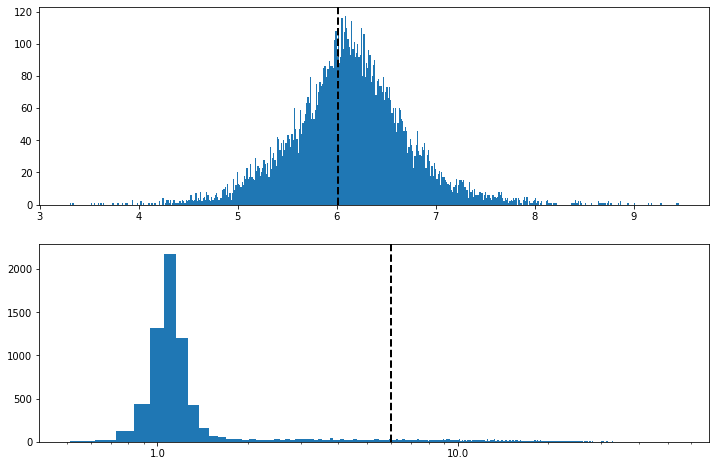

In [256]:
from matplotlib.ticker import ScalarFormatter
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
bins = 500


ax1.hist(traditional_cost, bins=bins)
ax1.axvline(BS_price,color='k',linestyle="--",linewidth=2)
ax2.hist(my_cost, bins=bins)
ax2.axvline(BS_price,color='k',linestyle="--",linewidth=2)
ax2.set_xscale("log")
ax2.xaxis.set_major_formatter(ScalarFormatter())
# ax2.xaxis.set_ticks([0.0,0.05,0.1,0.5,1.0,2,5,10])
# ax2.set_xticks([0.0,0.05,0.1,0.5,1.0,2.0]) 
# ax2.set_xticklabels([0.0,0.05,0.1,0.5,1.0,2.0], fontsize=12)


## Less rebalancing

In [261]:
S = 49
K = 50
tau = 20./52.
sigma = 0.5
r = 0.05
d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
d_minus = d_plus - sigma*np.sqrt(tau)
BS_price = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
print("Black-Scholes Price: ", BS_price)

Black-Scholes Price:  6.016573478964997


In [264]:
traditional_cost = []
my_cost = []
for i in range(10000):
    Scur = 49
    strike_price = 50
    rfRate = 0.5
    sigma = 0.5
    T = 20./52.
    dt = (1./52.)*2
    mu = 0.
    stock_args = (dt, T, Scur, mu, sigma, strike_price)

    hedge_types = ["long call","new long call"]
    my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

    S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()
    final_prices = my_delta_hedge.FINAL_PRICE
    traditional_cost.append(final_prices[0])
    my_cost.append(final_prices[1])
    
traditional_cost = np.array(traditional_cost)
my_cost = np.array(my_cost)

print("Avereage traditional: ",np.mean(traditional_cost),", Average of mine: ", np.mean(my_cost))
print("Variance traditional: ",np.var(traditional_cost),", Variance of mine: ", np.var(my_cost))

Avereage traditional:  12.532618951193745 , Average of mine:  7.326854913701017
Variance traditional:  2.9393662834811183 , Variance of mine:  57.1709449979103


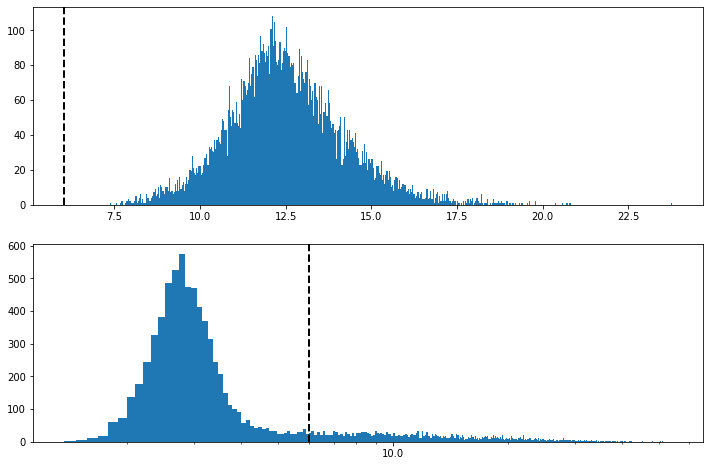

In [265]:
from matplotlib.ticker import ScalarFormatter
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
bins = 500


ax1.hist(traditional_cost, bins=bins)
ax1.axvline(BS_price,color='k',linestyle="--",linewidth=2)
ax2.hist(my_cost, bins=bins)
ax2.axvline(BS_price,color='k',linestyle="--",linewidth=2)
ax2.set_xscale("log")
ax2.xaxis.set_major_formatter(ScalarFormatter())
# ax2.xaxis.set_ticks([0.0,0.05,0.1,0.5,1.0,2,5,10])
# ax2.set_xticks([0.0,0.05,0.1,0.5,1.0,2.0]) 
# ax2.set_xticklabels([0.0,0.05,0.1,0.5,1.0,2.0], fontsize=12)


## Deep out-of-the-money and high volatility

In [272]:
S = 10
K = 50
tau = 20./52.
sigma = 1
r = 0.05
d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
d_minus = d_plus - sigma*np.sqrt(tau)
BS_price = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
print("Black-Scholes Price: ", BS_price)

Black-Scholes Price:  0.021638227112893788


In [273]:
traditional_cost = []
my_cost = []
for i in range(10000):
    Scur = 10
    strike_price = 50
    rfRate = 0.05
    sigma = 1
    T = 20./52.
    dt = (1./52.)*.25
    mu = 0.
    stock_args = (dt, T, Scur, mu, sigma, strike_price)

    hedge_types = ["long call","new long call"]
    my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

    S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()
    final_prices = my_delta_hedge.FINAL_PRICE
    traditional_cost.append(final_prices[0])
    my_cost.append(final_prices[1])
    
traditional_cost = np.array(traditional_cost)
my_cost = np.array(my_cost)

print("Avereage traditional: ",np.mean(traditional_cost),", Average of mine: ", np.mean(my_cost))
print("Variance traditional: ",np.var(traditional_cost),", Variance of mine: ", np.var(my_cost))

Avereage traditional:  0.020855225248999174 , Average of mine:  0.020754942949931094
Variance traditional:  0.008506535067307376 , Variance of mine:  0.23727427577996696


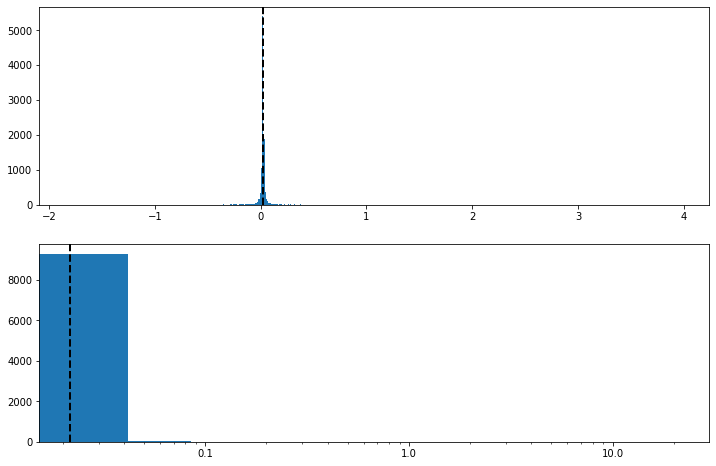

In [274]:
from matplotlib.ticker import ScalarFormatter
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
bins = 500


ax1.hist(traditional_cost, bins=bins)
ax1.axvline(BS_price,color='k',linestyle="--",linewidth=2)
ax2.hist(my_cost, bins=bins)
ax2.axvline(BS_price,color='k',linestyle="--",linewidth=2)
ax2.set_xscale("log")
ax2.xaxis.set_major_formatter(ScalarFormatter())
# ax2.xaxis.set_ticks([0.0,0.05,0.1,0.5,1.0,2,5,10])"
# ax2.set_xticks([0.0,0.05,0.1,0.5,1.0,2.0]) 
# ax2.set_xticklabels([0.0,0.05,0.1,0.5,1.0,2.0], fontsize=12)


## Deep in-the-money

In [275]:
S = 90
K = 50
tau = 20./52.
sigma = 0.1
r = 0.05
d_plus = (1/(sigma*np.sqrt(tau)))*( np.log(S/K) + (r + sigma*sigma/2)*tau )
d_minus = d_plus - sigma*np.sqrt(tau)
BS_price = S*norm.cdf(d_plus) - K*np.exp(-r*tau)*norm.cdf(d_minus)
print("Black-Scholes Price: ", BS_price)

Black-Scholes Price:  40.95235188198986


In [276]:
traditional_cost = []
my_cost = []
for i in range(10000):
    Scur = 90
    strike_price = 50
    rfRate = 0.05
    sigma = 0.1
    T = 20./52.
    dt = (1./52.)*2
    mu = 0.
    stock_args = (dt, T, Scur, mu, sigma, strike_price)

    hedge_types = ["long call","new long call"]
    my_delta_hedge = delta_hedge_process(hedge_types, rfRate, stock_args)

    S, cost, cumul_cost, shares, cumul_shares, interest = my_delta_hedge.process_to_maturity()
    final_prices = my_delta_hedge.FINAL_PRICE
    traditional_cost.append(final_prices[0])
    my_cost.append(final_prices[1])
    
traditional_cost = np.array(traditional_cost)
my_cost = np.array(my_cost)

print("Avereage traditional: ",np.mean(traditional_cost),", Average of mine: ", np.mean(my_cost))
print("Variance traditional: ",np.var(traditional_cost),", Variance of mine: ", np.var(my_cost))

Avereage traditional:  41.74582410979576 , Average of mine:  40.82420002648769
Variance traditional:  0.0 , Variance of mine:  9.687709066797995


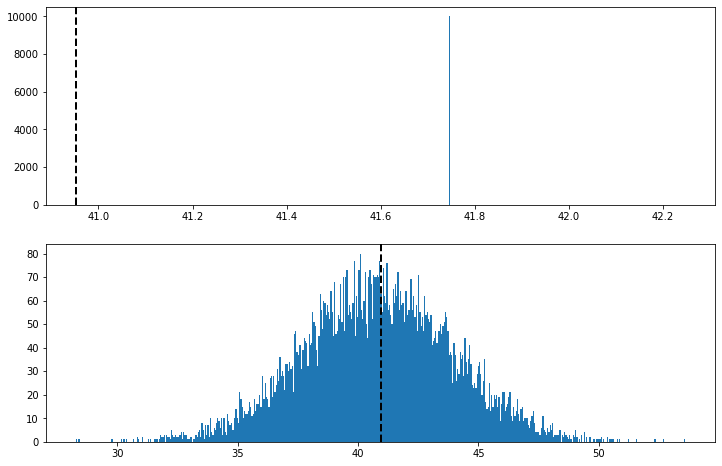

In [277]:
from matplotlib.ticker import ScalarFormatter
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
bins = 500


ax1.hist(traditional_cost, bins=bins)
ax1.axvline(BS_price,color='k',linestyle="--",linewidth=2)
ax2.hist(my_cost, bins=bins)
ax2.axvline(BS_price,color='k',linestyle="--",linewidth=2)
# ax2.set_xscale("log")
# ax2.xaxis.set_major_formatter(ScalarFormatter())
# ax2.xaxis.set_ticks([0.0,0.05,0.1,0.5,1.0,2,5,10])"
# ax2.set_xticks([0.0,0.05,0.1,0.5,1.0,2.0]) 
# ax2.set_xticklabels([0.0,0.05,0.1,0.5,1.0,2.0], fontsize=12)
